---

1. Calculate the expected value and variance of the subtotal column in the dataset. What do these values represent in the context of this data?

2. First, calculate the skew of subtotal. Then, calculate the mean and variance of the original subtotal. After that, transform the subtotal variable using the square root transformation 𝑌 = the square root of 𝑋, where 𝑋 is the original subtotal. Finally, calculate the skew of the transformed subtotal.

3. Determine the correlation between total_items and subtotal. What does the sign and magnitude of this correlation indicate about the relationship between the number of items in an order and the total order amount?

4. Assume the number of total_outstanding_orders follows a Poisson distribution. Estimate the rate parameter (
𝜆) for the Poisson distribution using the data, and then calculate the probability that there are exactly 25 outstanding orders.

5. Given that estimated_store_to_consumer_driving_duration follows an exponential distribution, estimate the rate parameter (
𝜆) for this distribution. Then calculate the probability that the driving duration is less than 10 minutes.

## About the data:
The dataset contains a subset of deliveries received at DoorDash in early 2015 in a subset of the cities. Each row in this file corresponds to one unique delivery. Each column corresponds to a feature as explained below. Note all money (dollar) values given in the data are in cents and all time duration values given are in seconds
\
\
**Time features:**\
**market_id**: A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id
**created_at**: Timestamp in UTC when the order was submitted by the consumer to DoorDash. (Note this timestamp is in UTC, but in case you need it, the actual timezone of the region was US/Pacific)
**actual_delivery_time**: Timestamp in UTC when the order was delivered to the consumer
**delivery_time_seconds**: Subtracted 'created_at' from 'actual_delivery_time' after converting both to datetimes. This is in seconds.
\
\
**Store features:**\
**store_id**: an id representing the restaurant the order was submitted for
**store_primary_category**: cuisine category of the restaurant, e.g., italian, asian
**order_protocol**: a store can receive orders from DoorDash through many modes. This field represents an id denoting the protocol
\
\
**Order features:**\
**total_items**: total number of items in the order
**subtotal**: total value of the order submitted (in cents)
**num_distinct_items**: number of distinct items included in the order
**min_item_price**: price of the item with the least cost in the order (in cents)
**max_item_price**: price of the item with the highest cost in the order (in cents)
\
\
**Market features:**\
DoorDash being a marketplace, we have information on the state of marketplace when the order is placed, that can be used to estimate delivery time. The following features are values at the time of `created_at` (order submission time)
**total_onshift_dashers**: Number of available dashers who are within 10 miles of the store at the time of order creation
**total_busy_dashers**: Subset of above `total_onshift_dashers` who are currently working on an order
**total_outstanding_orders**: Number of orders within 10 miles of this order that are currently being processed.

# Code below

### Prep the environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.stats import skew
from scipy.stats import poisson
from scipy.stats import expon

Read the delivery_data_clean into the environment and look at it

In [2]:
# URL of the CSV file
url = "https://github.com/alee103/intro_to_stats/raw/main/delivery_data_clean.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(url)

# Display the first few rows of the DataFrame
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_time_seconds
0,2.0,2015-01-29 02:59:44,2015-01-29 03:37:58,6865,mexican,5.0,1,1499,1,799,799,103.0,87.0,127.0,251,609.0,2294.0
1,1.0,2015-01-31 02:12:31,2015-01-31 03:11:51,3368,pizza,3.0,3,3722,3,499,1399,22.0,22.0,23.0,251,576.0,3560.0
2,5.0,2015-02-12 23:49:21,2015-02-13 00:23:29,5370,american,5.0,2,1935,2,645,995,7.0,3.0,3.0,251,660.0,2048.0
3,4.0,2015-01-23 01:13:15,2015-01-23 01:57:50,558,seafood,5.0,5,5500,4,750,1600,47.0,36.0,53.0,251,690.0,2675.0
4,1.0,2015-02-01 03:07:00,2015-02-01 03:40:23,2582,barbecue,1.0,1,925,1,925,925,58.0,55.0,41.0,446,217.0,2003.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70333 entries, 0 to 70332
Data columns (total 17 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   market_id                                     70333 non-null  float64
 1   created_at                                    70333 non-null  object 
 2   actual_delivery_time                          70333 non-null  object 
 3   store_id                                      70333 non-null  int64  
 4   store_primary_category                        70333 non-null  object 
 5   order_protocol                                70333 non-null  float64
 6   total_items                                   70333 non-null  int64  
 7   subtotal                                      70333 non-null  int64  
 8   num_distinct_items                            70333 non-null  int64  
 9   min_item_price                                70333 non-null 

Check the summary statistics. Note that the minimum value for min_item_price is negative. This is important to note for the transformation because some of them can't handle negative values.

In [4]:
df.describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_time_seconds
count,70333.000000,70333.000000,70333.000000,70333.000000,70333.000000,70333.000000,70333.000000,70333.000000,70333.000000,70333.000000,70333.000000,70333.000000,70333.000000,70333.000000
mean,2.751539,3576.408827,2.918957,2.729188,2264.675103,2.401334,653.504756,1056.799696,40.378826,37.729146,50.009739,307.622553,540.622140,2649.214409
std,1.342984,2058.842148,1.519546,1.460103,1198.407905,1.224272,404.040266,376.437363,29.943360,28.192049,42.556538,88.937288,216.791286,845.524113
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,-51.000000,52.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,223.000000
25%,2.000000,1713.000000,1.000000,2.000000,1320.000000,1.000000,300.000000,795.000000,16.000000,14.000000,16.000000,251.000000,378.000000,2024.000000
50%,2.000000,3648.000000,3.000000,2.000000,2000.000000,2.000000,599.000000,1000.000000,34.000000,31.000000,37.000000,251.000000,539.000000,2537.000000
75%,4.000000,5370.000000,4.000000,4.000000,2986.000000,3.000000,905.000000,1299.000000,59.000000,57.000000,74.000000,446.000000,697.000000,3171.000000
max,6.000000,6986.000000,7.000000,7.000000,6065.000000,6.000000,1910.000000,2101.000000,134.000000,127.000000,174.000000,695.000000,1182.000000,5093.000000


In [5]:
# Check how many rows have negative values for min item price
df[df['min_item_price'] < 0]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_time_seconds
23077,5.0,2015-02-14 22:01:48,2015-02-14 23:15:15,2276,pizza,3.0,1,3099,1,-31,52,22.0,26.0,34.0,251,377.0,4407.0
55205,5.0,2015-02-02 20:22:39,2015-02-02 21:03:12,2651,fast,4.0,3,951,2,-51,804,21.0,16.0,39.0,251,244.0,2433.0
68277,1.0,2015-02-10 03:31:22,2015-02-10 04:02:08,2054,italian,5.0,5,2585,3,-7,1235,49.0,47.0,59.0,251,333.0,1846.0


We're not sure what's going on with the negative values, so we're just going to remove these three rows - three rows of data is a very small percentage of the data, so it won't have a large impact on the analysis - for the purpose of this specific example. It might be discounts, a recording error, or something else. In a real scenario, we would investigate this further. 

In [6]:
# Remove rows with negative values for min item price
df = df[df['min_item_price'] > 0]

In [7]:
df['min_item_price'].min()

10

### Calculate the expected value and variance of the `subtotal` column

In [8]:
expected_value_min_price = df['min_item_price'].mean() 
var_min_price = df['min_item_price'].var()

expected_value_min_price, var_min_price

(657.9683778057719, 161425.41970005012)

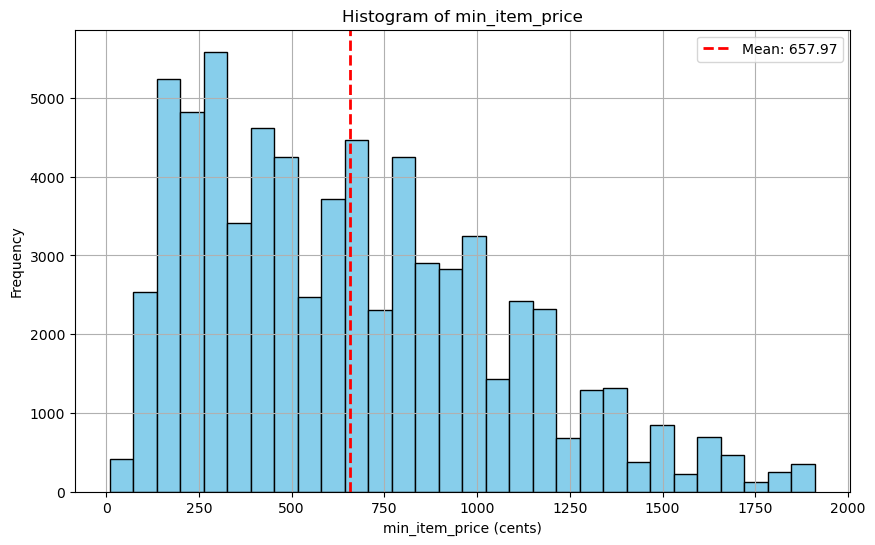

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(df['min_item_price'], bins=30, color='skyblue', edgecolor='black')
plt.axvline(expected_value_min_price, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {expected_value_min_price:.2f}')
plt.title('Histogram of min_item_price')
plt.xlabel('min_item_price (cents)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

### First, calculate the skew of subtotal. Then, calculate the mean and variance of the original subtotal. After that, transform the subtotal variable using the square root transformation 𝑌 = the square root of 𝑋, where 𝑋 is the original subtotal. Finally, calculate the skew of the transformed subtotal.

In [10]:
min_price_skew = skew(df['min_item_price'])
min_price_skew

0.6706313492630329

In [11]:
expected_value_min_price = df['min_item_price'].mean() 
var_min_price = df['min_item_price'].var()

expected_value_min_price, var_min_price

(657.9683778057719, 161425.41970005012)

In [12]:
# Step 3: Apply the square root transformation to `min_item_price`
df['sqrt_min_item_price'] = np.sqrt(df['min_item_price'])

# Step 4: Calculate the mean and variance of the transformed `sqrt_subtotal`
mean_sqrt_min_item = df['sqrt_min_item_price'].mean()
variance_sqrt_min_item = df['sqrt_min_item_price'].var()

print(f"Square Root-Transformed Min price - Mean: {mean_sqrt_min_item}, Variance: {variance_sqrt_min_item}")

Square Root-Transformed Min price - Mean: 24.37000777000761, Variance: 64.07201629686315


In [13]:
min_skewness = skew(df['sqrt_min_item_price'])

print(f"Skewness of 'sqrt_min_item_price': {min_skewness}")

Skewness of 'sqrt_min_item_price': 0.08474977816563739


In [14]:
df[['min_item_price','sqrt_min_item_price']].head()

,min_item_price,sqrt_min_item_price
0,799,28.266588
1,499,22.338308
2,645,25.396850
3,750,27.386128
4,925,30.413813


### 3: Determine the correlation between `total_items` and `subtotal`

In [15]:
correlation_total_items_subtotal = df['total_items'].corr(df['min_item_price'])
correlation_total_items_subtotal

-0.5457808573509895

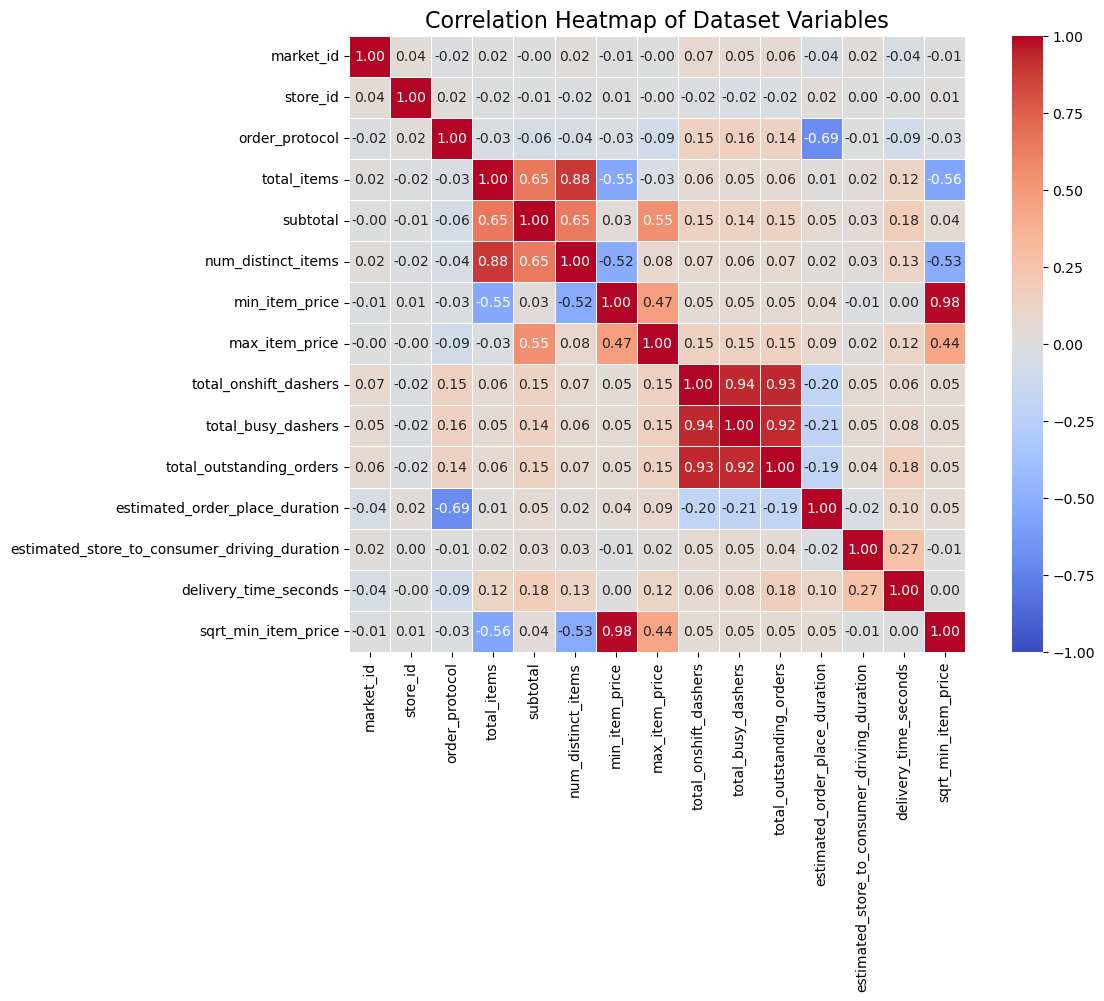

In [16]:
num_cols = df.select_dtypes(include=[np.number]).columns

# Calculate the correlation matrix
corr_matrix = df[num_cols].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, square=True, linewidths=.5)

# Add title and adjust layout
plt.title('Correlation Heatmap of Dataset Variables', fontsize=16)
plt.show()

### Estimate the rate parameter (lambda) and calculate probability for exactly 25 outstanding orders

In [17]:
# Estimate the rate parameter (lambda) as the mean of 'total_items'
lambda_total_items = df['total_items'].mean()

# Calculate the probability of exactly 3 total_items
prob_3_total_items = poisson.pmf(3, lambda_total_items)

lambda_total_items, prob_3_total_items

(2.7194228126431517, 0.22092691970841782)

### Estimate the rate parameter (lambda) and calculate probability for less than 10 minutes

In [18]:
# Estimate the rate parameter (lambda) as the inverse of the mean estimated_order_place_duration (in seconds)
mean_order_duration = df['estimated_order_place_duration'].mean()
lambda_order_duration = 1 / mean_order_duration

# Convert 5 minutes to seconds
threshold_in_seconds = 5 * 60

# Calculate the probability that the order_place_duration is less than 5 minutes (in seconds)
prob_less_than_5_minutes = expon.cdf(threshold_in_seconds, scale=1/lambda_order_duration)

lambda_order_duration, prob_less_than_5_minutes

(0.0032504270326685226, 0.6228559653788985)

In [19]:
# What is the expected value and variance of the subtotal column in the dataset?

expected_value_subtotal = df['subtotal'].mean()
variance_subtotal = df['subtotal'].var()

expected_value_subtotal, variance_subtotal

(2264.975564017407, 1435733.1219710559)

Square Root-Transformed Subtotal - Mean: 45.95195929523475, Variance: 153.3951968236818
0.2944287317318237


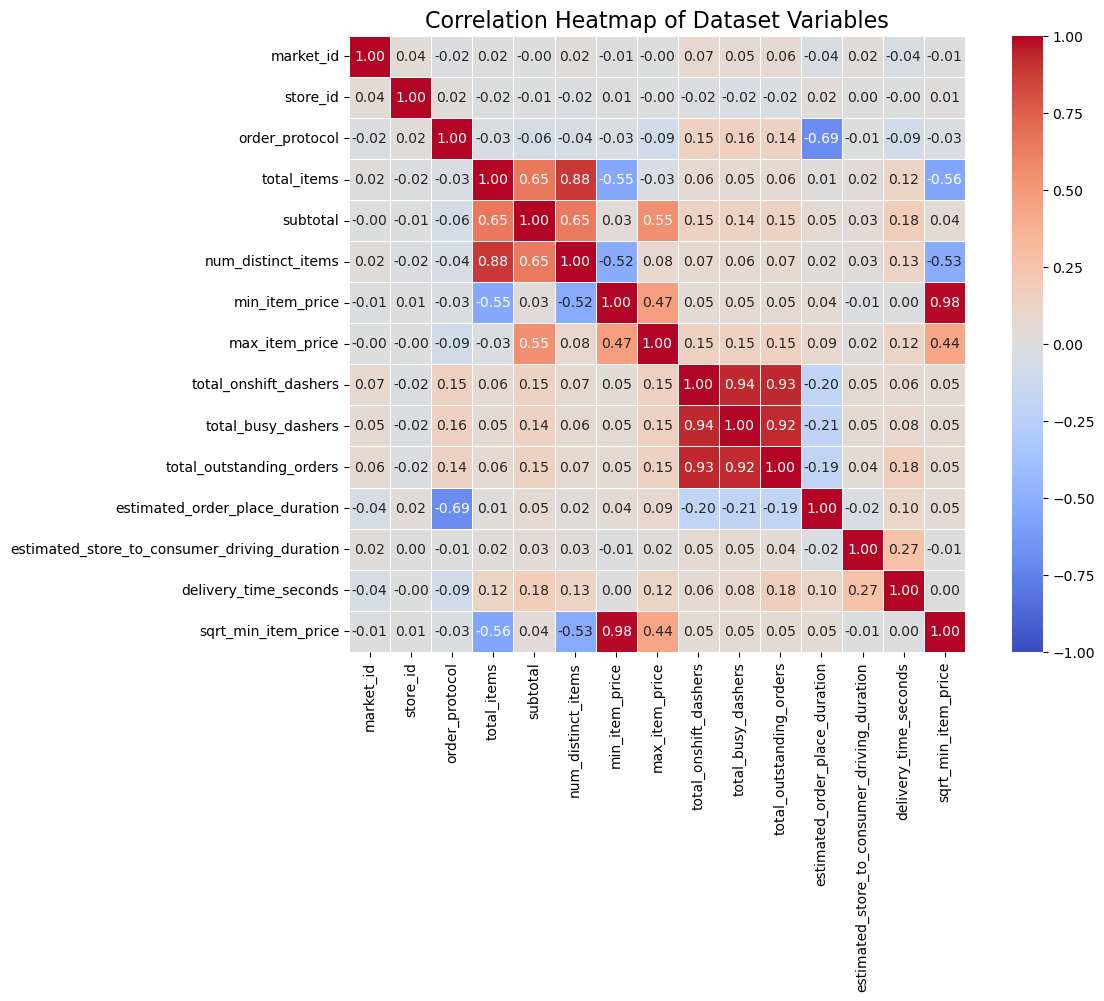

In [22]:
# What is the skew of the transformed subtotal?

# Step 3: Apply the square root transformation to `subtotal`
df['sqrt_subtotal'] = np.sqrt(df['subtotal'])

# Step 4: Calculate the mean and variance of the transformed `sqrt_subtotal`
mean_sqrt_subtotal = df['sqrt_subtotal'].mean()
variance_sqrt_subtotal = df['sqrt_subtotal'].var()

print(f"Square Root-Transformed Subtotal - Mean: {mean_sqrt_subtotal}, Variance: {variance_sqrt_subtotal}")

# Calculate the skewness of the transformed `sqrt_subtotal`
skew_sqrt_subtotal = skew(df['sqrt_subtotal'])
print(skew_sqrt_subtotal)

# What is the correlation between the total_items and subtotal columns in the dataset?

# Calculate the correlation between 'total_items' and 'subtotal'
correlation_total_items_subtotal = df['total_items'].corr(df['subtotal'])
correlation_total_items_subtotal

# Calculate the correlation matrix
corr_matrix = df[num_cols].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, square=True, linewidths=.5)

# Add title and adjust layout
plt.title('Correlation Heatmap of Dataset Variables', fontsize=16)
plt.show()


(540.7369875171782, 1.0)